In [4]:
"""
    The SC LSTM-CNN model for stock price prediction
"""
import os
import functools
import multiprocessing
import numpy as np
import tensorflow as tf
import logging
from tensorflow.keras import layers, models
from charts import (
    create_bar_candlestick_fusion_chart,
    create_bar_line_fusion_chart,
    create_bar_filled_line_fusion_chart
)
from setting import (
    TRAIN_SP500_DATA_FILE, ALPHA, BETA, GAMMA, ENABLE_IMAGE_DECODE,
    WINDOW_SIZE, BATCH_SIZE, EPOCH, PREDICT_SIZE, TEST_SP500_DATA_FILE, 
    VALIDATION_SP500_DATA_FILE, CHART_DIR
)
from util import convert_to_list

def load_csv_data(file_path, **kwargs):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path, batch_size=1, na_value="0",
        header=True, shuffle=False, num_epochs=1,
        ignore_errors=True, **kwargs
    )
    return dataset


def make_dataset_generator_for_lstmcnn_model(fn_draw_chart, window_size=30, predict_size=5, path_to_csv='', dataset_type=''):
    chart_dir = os.path.join(CHART_DIR, dataset_type)
    def create_window_timeseries_dataset():
        """window + predict_size time series dataset"""
        frame_index = 0
        dataset = load_csv_data(path_to_csv)
        sidding_window_dataset: tf.data.Dataset = dataset.window(
            size=window_size + predict_size, shift=1,
            drop_remainder=True
        )
        data_frame: tf.data.Dataset

        for data_frame in sidding_window_dataset.take(-1):
            all_frame_close_prices = convert_to_list(data_frame['Trade Close'])
            predict_price = all_frame_close_prices[window_size + predict_size - 1]
            data_frame['Time'] = data_frame['Time'].take(window_size)
            data_frame['Trade High'] = data_frame['Trade High'].take(window_size)
            data_frame['Trade Low'] = data_frame['Trade Low'].take(window_size)
            data_frame['Trade Volume'] = data_frame['Trade Volume'].take(window_size)
            data_frame['Trade Open'] = data_frame['Trade Open'].take(window_size)
            data_frame['Trade Close'] = data_frame['Trade Close'].take(window_size)
            trade_volume = convert_to_list(data_frame['Trade Volume'])
            close_price = convert_to_list(data_frame['Trade Close'])
            normed_close_price = np.log10(np.array(close_price[:-1])) /  np.log10(np.array(close_price[1:]))
            normed_trade_volume = np.log10(np.array(trade_volume[:-1])) /  np.log10(np.array(trade_volume[1:]))
            frame_index += 1
            yield (
                tf.convert_to_tensor(np.reshape(np.array([normed_close_price, normed_trade_volume]), [29, 2])), 
                fn_draw_chart("frame_%s" % frame_index, data_frame, chart_dir=chart_dir)
            ), predict_price
    return create_window_timeseries_dataset


def make_dataset_generator_for_lstm(window_size=30, predict_size=5, path_to_csv=''):
    def create_window_timeseries_dataset():
        """window + predict_size time series dataset"""
        dataset = load_csv_data(path_to_csv)
        sidding_window_dataset: tf.data.Dataset = dataset.window(
            size=window_size + predict_size, shift=1,
            drop_remainder=True
        )
        data_frame: tf.data.Dataset

        for data_frame in sidding_window_dataset.take(-1):
            all_frame_close_prices = convert_to_list(data_frame['Trade Close'])
            predict_price = all_frame_close_prices[window_size + predict_size - 1]
            data_frame['Trade Volume'] = data_frame['Trade Volume'].take(window_size)
            data_frame['Trade Close'] = data_frame['Trade Close'].take(window_size)
            trade_volume = convert_to_list(data_frame['Trade Volume'])
            close_price = convert_to_list(data_frame['Trade Close'])
            normed_close_price = np.log10(np.array(close_price[:-1])) /  np.log10(np.array(close_price[1:]))
            normed_trade_volume = np.log10(np.array(trade_volume[:-1])) /  np.log10(np.array(trade_volume[1:]))
            log_input = tf.convert_to_tensor(
                np.reshape(np.array([normed_close_price, normed_trade_volume]), [29, 2])
            )
            yield log_input, predict_price
    return create_window_timeseries_dataset


def make_dataset_generator_for_chart_data(fn_draw_chart, window_size=30, predict_size=5, path_to_csv='', dataset_type=''):
    chart_dir = os.path.join(CHART_DIR, dataset_type)
    def create_window_timeseries_dataset():
        """window + predict_size time series dataset"""
        frame_index = 0
        dataset = load_csv_data(path_to_csv)
        sidding_window_dataset: tf.data.Dataset = dataset.window(
            size=window_size + predict_size, shift=1,
            drop_remainder=True
        )
        data_frame: tf.data.Dataset
        for data_frame in sidding_window_dataset.take(-1):
            all_frame_close_prices = convert_to_list(data_frame['Trade Close'])
            predict_price = all_frame_close_prices[window_size + predict_size - 1]
            data_frame['Time'] = data_frame['Time'].take(window_size)
            data_frame['Trade High'] = data_frame['Trade High'].take(window_size)
            data_frame['Trade Low'] = data_frame['Trade Low'].take(window_size)
            data_frame['Trade Volume'] = data_frame['Trade Volume'].take(window_size)
            data_frame['Trade Open'] = data_frame['Trade Open'].take(window_size)
            data_frame['Trade Close'] = data_frame['Trade Close'].take(window_size)
            frame_index += 1
            yield fn_draw_chart("frame_%s" % frame_index, data_frame, chart_dir=chart_dir), predict_price
    return create_window_timeseries_dataset


def fn_task_generate_filled_line_fusion(path_to_csv, dataset_type):
    """Process data"""
    dataset: tf.data.Dataset = tf.data.Dataset.from_generator(
        make_dataset_generator_for_chart_data(
            create_bar_filled_line_fusion_chart,
            window_size=WINDOW_SIZE,
            predict_size=PREDICT_SIZE,
            path_to_csv=path_to_csv,
            dataset_type=dataset_type
        ),
        output_types=(tf.float64, tf.float16),
        output_shapes=(tf.TensorShape([]), tf.TensorShape([]))
    )
    total = 0
    for _record in dataset.batch(1).take(-1):
        logging.warning(total)
        total += 1


def fn_task_generate_candlestick_fusion(path_to_csv, dataset_type):
    """Process data"""
    dataset: tf.data.Dataset = tf.data.Dataset.from_generator(
        make_dataset_generator_for_chart_data(
            create_bar_candlestick_fusion_chart,
            window_size=WINDOW_SIZE,
            predict_size=PREDICT_SIZE,
            path_to_csv=path_to_csv,
            dataset_type=dataset_type
        ),
        output_types=(tf.float64, tf.float16),
        output_shapes=(tf.TensorShape([]), tf.TensorShape([]))
    )
    total = 0
    for _record in dataset.batch(1).take(-1):
        logging.warning(total)
        total += 1


def fn_task_generate_barline_fusion(path_to_csv, dataset_type):
    """Process data"""
    dataset: tf.data.Dataset = tf.data.Dataset.from_generator(
        make_dataset_generator_for_chart_data(
            create_bar_line_fusion_chart,
            window_size=WINDOW_SIZE,
            predict_size=PREDICT_SIZE,
            path_to_csv=path_to_csv,
            dataset_type=dataset_type
        ),
        output_types=(tf.float64, tf.float16),
        output_shapes=(tf.TensorShape([]), tf.TensorShape([]))
    )
    total = 0
    for _record in dataset.batch(1).take(-1):
        logging.warning(total)
        total += 1


def generate_chart_dataset(path_to_csv, dataset_type):
    """create the dataset"""
    worker1 = multiprocessing.Process(
        target=fn_task_generate_filled_line_fusion, args=(path_to_csv, dataset_type)
    )
    worker2 = multiprocessing.Process(
        target=fn_task_generate_candlestick_fusion, args=(path_to_csv, dataset_type)
    )
    worker3 = multiprocessing.Process(
        target=fn_task_generate_barline_fusion, args=(path_to_csv, dataset_type)
    )
    worker1.start()
    worker2.start()
    worker3.start()
    worker1.join()
    worker2.join()
    worker3.join()


def load_lstm_dataset(window_size, predict_size, path_to_csv):
    """Load lstm dataset"""
    dataset: tf.data.Dataset = tf.data.Dataset.from_generator(
        make_dataset_generator_for_lstm(
            window_size=window_size, predict_size=predict_size, path_to_csv=path_to_csv
        ),
        output_types=(tf.float64, tf.float16),
        output_shapes=(tf.TensorShape((29, 2)), tf.TensorShape([]))
    )
    return dataset


def load_cnn_dataset(window_size, predict_size, fn_draw_chart, path_to_csv, dataset_type):
    """Load CNN dataset"""
    dataset: tf.data.Dataset = tf.data.Dataset.from_generator(
        make_dataset_generator_for_chart_data(
            fn_draw_chart, window_size=window_size, predict_size=predict_size,
            path_to_csv=path_to_csv, dataset_type=dataset_type
        ),
        output_types=(tf.float64, tf.float16),
        output_shapes=(tf.TensorShape((112, 112, 3)), tf.TensorShape([]))
    )
    return dataset
    # return dataset.take(-1)


def load_lstm_cnn_dataset(window_size, predict_size, fn_draw_chart, path_to_csv, dataset_type):
    """Load LSTM CNN dataset"""
    dataset: tf.data.Dataset = tf.data.Dataset.from_generator(
        make_dataset_generator_for_lstmcnn_model(
            fn_draw_chart, window_size=window_size, predict_size=predict_size,
            path_to_csv=path_to_csv, dataset_type=dataset_type
        ),
        output_types=((tf.float64, tf.float32), tf.float16),
        output_shapes=((tf.TensorShape([29, 2]), tf.TensorShape((112, 112, 3))), tf.TensorShape([]))
    )
    return dataset

if __name__ == "__main__":
    if not ENABLE_IMAGE_DECODE:
        generate_chart_dataset(TRAIN_SP500_DATA_FILE, 'train')
    else:
        logging.error("Please set ENABLE_IMAGE_DECODE=False in the setting file")


In [5]:
"""
    Shortcut connection CNN model
"""
import os
import argparse
import json
import logging
import tensorflow as tf
from tensorflow.keras import layers, models

from charts import create_bar_filled_line_fusion_chart
from setting import (ENABLE_IMAGE_DECODE, PREDICT_SIZE,
                     TEST_SP500_DATA_FILE, TRAIN_SP500_DATA_FILE,
                     VALIDATION_SP500_DATA_FILE, WINDOW_SIZE,
                     NUMBER_OF_VALIDATION, EPOCH, BATCH_SIZE,
                     LEARNING_RATE, EPSILON)

from stock_dataset import load_cnn_dataset

from util import get_cache_file, get_log_dir, set_gpu_memory_limit, RMAE


def create_res_conv1_layer(input):
    """Create the res conv1 layer"""
    shortcut_conv1 = layers.Conv2D(
        128, (1, 1), strides=1, padding='VAlID',
        input_shape=(28, 28, 32), name="shortcut_conv1"
    )(input)

    resconv1_1x1_kernel_in = layers.Conv2D(
        128, (1, 1), strides=1, padding='VAlID',
        input_shape=(28, 28, 32), name="resconv1_1x1_kernel_in", activation='relu'
    )(input)

    resconv1_3x3_kernel = layers.Conv2D(
        128, (3, 3), strides=1, padding='SAME',
        input_shape=(28, 28, 128), name="resconv1_3x3_kernel", activation='relu'
    )(resconv1_1x1_kernel_in)

    conv1x1_out = layers.Conv2D(
        128, (1, 1), strides=1, padding='VALID',
        input_shape=(28, 28, 128), name="resconv1_1x1_kernel_out", activation='relu'
    )(resconv1_3x3_kernel)
    return layers.ReLU()(layers.Add(name="res_conv1_add_shortcut1")([conv1x1_out, shortcut_conv1]))


def create_res_conv2_layer(input):
    """Create the res conv1 layer"""
    shortcut_conv2 = layers.Conv2D(
        256, (1, 1), strides=2, padding='VAlID',
        input_shape=(28, 28, 128), name="shortcut_conv2"
    )(input)

    resconv2_1x1_kernel_in = layers.Conv2D(
        256, (1, 1), strides=2, padding='VAlID',
        input_shape=(28, 28, 128), name="resconv2_1x1_kernel_in", activation='relu'
    )(input)

    resconv2_3x3_kernel = layers.Conv2D(
        128, (3, 3), strides=1, padding='SAME',
        input_shape=(14, 14, 256), name="resconv2_3x3_kernel", activation='relu'
    )(resconv2_1x1_kernel_in)

    resconv2_1x1_kernel_out = layers.Conv2D(
        256, (1, 1), strides=1, padding='VALID',
        input_shape=(14, 14, 256), name="resconv2_1x1_kernel_out", activation='relu'
    )(resconv2_3x3_kernel)
    return layers.ReLU()(layers.Add(name="res_conv2_add_shortcut2")([resconv2_1x1_kernel_out, shortcut_conv2]))


def create_res_conv3_layer(input):
    """Create the res conv1 layer"""
    shortcut_conv3 = layers.Conv2D(
        512, (1, 1), strides=2, padding='VAlID',
        input_shape=(28, 28, 256), name="shortcut_conv3"
    )(input)

    resconv3_1x1_kernel_in = layers.Conv2D(
        512, (1, 1), strides=2, padding='VAlID',
        input_shape=(28, 28, 256), name="resconv3_1x1_kernel_in", activation='relu'
    )(input)

    resconv3_3x3_kernel = layers.Conv2D(
        512, (3, 3), strides=1, padding='SAME',
        input_shape=(7, 7, 512), name="resconv3_3x3_kernel", activation='relu'
    )(resconv3_1x1_kernel_in)

    resconv3_1x1_kernel_out = layers.Conv2D(
        512, (1, 1), strides=1, padding='VALID',
        input_shape=(7, 7, 512), name="resconv3_1x1_kernel_out", activation='relu'
    )(resconv3_3x3_kernel)
    return layers.ReLU()(layers.Add(name="res_conv3_add_shortcut3")([resconv3_1x1_kernel_out, shortcut_conv3]))


def zero_pad2d(x, padding):
    """Zero padding 2d for inputs"""
    return layers.ZeroPadding2D(padding=padding, data_format="channels_last")(x)


def create_residual_cnn_model(chart_inputs: tf.keras.Input) -> models.Model:
    """Create the residual leaning CNN model"""
    # Conv1 layer
    conv1_layer = layers.Conv2D(
        32, (7, 7), strides=(2, 2), padding='valid',
        input_shape=(112, 112, 3), name="CONV1", activation="relu",
        data_format="channels_last"
    )(zero_pad2d(chart_inputs, 3))

    # Max pooling layer
    max_pool_layer = layers.MaxPool2D(
        pool_size=(3, 3), padding='VALID', strides=(2, 2),
        name="MaxPooling"
    )(conv1_layer)

    res_conv1 = create_res_conv1_layer(max_pool_layer)
    res_conv2 = create_res_conv2_layer(res_conv1)
    res_conv3 = create_res_conv3_layer(res_conv2)
    average_pool = layers.Flatten()(layers.AveragePooling2D(pool_size=(7,7))(res_conv3))

    full_connected_1 = layers.Dropout(0.5)(
        layers.Dense(500, activation='relu', use_bias=True)(average_pool)
    )
    full_connected_2 = layers.Dropout(0.5)(
        layers.Dense(100, activation='relu', use_bias=True)(full_connected_1)
    )
    full_connected_3 = layers.Dropout(0.5)(
        layers.Dense(25, activation='relu', use_bias=True)(full_connected_2)
    )
    # return full_connected_3
    output_layer = layers.Dense(1, activation='linear')(full_connected_3)
    return output_layer, average_pool


if __name__ == "__main__":
    import easydict
    train_args = easydict.EasyDict({
        "name":"train",
        "epoch":1,
        "batch_size":BATCH_SIZE,
        "learning_rate":LEARNING_RATE,
        "epsilon":EPSILON
    })

    tf.print("---------------------------------------------")
    tf.print(train_args.name)
    tf.print(train_args.epoch)
    tf.print(train_args.batch_size)
    tf.print(train_args.learning_rate)
    tf.print(train_args.epsilon)
    tf.print("---------------------------------------------")

    set_gpu_memory_limit(0, 2000)
    if ENABLE_IMAGE_DECODE:
        train_dataset: tf.data.Dataset = load_cnn_dataset(
            WINDOW_SIZE, PREDICT_SIZE, create_bar_filled_line_fusion_chart,
            path_to_csv=TRAIN_SP500_DATA_FILE, dataset_type='train'
        )
        train_dataset = train_dataset.cache(get_cache_file('train', 'cnn'))
        train_dataset = train_dataset.batch(train_args.batch_size, drop_remainder=True)


        validation_dataset: tf.data.Dataset = load_cnn_dataset(
            WINDOW_SIZE, PREDICT_SIZE, create_bar_filled_line_fusion_chart,
            path_to_csv=VALIDATION_SP500_DATA_FILE, dataset_type='validation'
        )
        validation_dataset = validation_dataset.cache(get_cache_file('validation', 'cnn'))
        validation_dataset = validation_dataset.repeat().batch(train_args.batch_size, drop_remainder=True)


        test_dataset: tf.data.Dataset = load_cnn_dataset(
            WINDOW_SIZE, PREDICT_SIZE, create_bar_filled_line_fusion_chart,
            path_to_csv=TEST_SP500_DATA_FILE, dataset_type='test'
        )
        test_dataset = test_dataset.cache(get_cache_file('test', 'cnn'))
        test_dataset = test_dataset.batch(train_args.batch_size, drop_remainder=True)

        # Model
        chart_inputs = tf.keras.Input(batch_input_shape=(train_args.batch_size, 112, 112, 3))
        cnn_model = models.Model(
            inputs=chart_inputs, 
            outputs=create_residual_cnn_model(chart_inputs)[0]
        )
        cnn_model.summary()

        adam_optimizer = tf.keras.optimizers.Adam(
            learning_rate=train_args.learning_rate, epsilon=train_args.epsilon
        )

        log_dir = get_log_dir("cnn", train_args.name)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        cnn_model.compile(
            optimizer=adam_optimizer, loss=tf.losses.MeanSquaredError(),
            metrics=['mape', tf.keras.metrics.RootMeanSquaredError(name='rmse'), RMAE]
        )
        validation_steps = int(NUMBER_OF_VALIDATION/train_args.batch_size)

        tf.print("Training model")
        # training model
        cnn_model.fit(
            train_dataset, epochs=train_args.epoch, verbose=1, batch_size=train_args.batch_size,
            validation_data=validation_dataset,
            validation_steps=validation_steps,
            callbacks=[tensorboard_callback]
        )
        tf.print("Evaluating CNN model")
        result = cnn_model.evaluate(
            test_dataset, batch_size=train_args.batch_size,
            callbacks=[tensorboard_callback]
        )
        tf.print("Metric score:")
        tf.print(dict(zip(cnn_model.metrics_names, result)))
        with open(os.path.join(log_dir, "evaluation.json"), 'w') as evalfobj:
            json.dump(dict(zip(cnn_model.metrics_names, result)), evalfobj)
            
        cnn_model.save("CNN_model_epoch_1.h5")    
    else:
        logging.error("Please enable ENABLE_IMAGE_DECODE for training model")


---------------------------------------------
train
1
32
0.003
0.1
---------------------------------------------


ERROR:root:Please enable ENABLE_IMAGE_DECODE for training model


In [6]:
"""
    Shortcut connection CNN model // LSTM
"""
import os
import json
import argparse
import logging
import tensorflow as tf
from tensorflow.keras import layers, models

from setting import (ENABLE_IMAGE_DECODE, PREDICT_SIZE,
                     TEST_SP500_DATA_FILE, TRAIN_SP500_DATA_FILE,
                     VALIDATION_SP500_DATA_FILE, WINDOW_SIZE, NUMBER_OF_VALIDATION,
                     WINDOW_SIZE, EPOCH, BATCH_SIZE, LEARNING_RATE, EPSILON)

from stock_dataset import load_lstm_dataset
from util import get_cache_file, get_log_dir, set_gpu_memory_limit, RMAE


def create_lstm_model(log_inputs: tf.keras.Input) -> layers.Layer:
    lstm_layer_1 = layers.LSTM(29, batch_input_shape=(None, 29, 2), return_sequences=True)(log_inputs)
    lstm_layer_2 = layers.LSTM(29, batch_input_shape=(None, 29, 29))(lstm_layer_1)
    flatten_layer = layers.Flatten()(lstm_layer_2)
    full_connected_1 = layers.Dropout(0.5)(
        layers.Dense(500, activation='relu', use_bias=True)(flatten_layer)
    )
    full_connected_2 = layers.Dropout(0.5)(
        layers.Dense(100, activation='relu', use_bias=True)(full_connected_1)
    )
    full_connected_3 = layers.Dropout(0.5)(
        layers.Dense(25, activation='relu', use_bias=True)(full_connected_2)
    )
    output_layer = layers.Dense(1, activation='linear')(full_connected_3)
    return output_layer, flatten_layer

if __name__ == "__main__":
    import easydict
    train_args = easydict.EasyDict({
        "name":"train",
        "epoch":1,
        "batch_size":BATCH_SIZE,
        "learning_rate":LEARNING_RATE,
        "epsilon":EPSILON
    })

    tf.print("---------------------------------------------")
    tf.print(train_args.name)
    tf.print(train_args.epoch)
    tf.print(train_args.batch_size)
    tf.print(train_args.learning_rate)
    tf.print(train_args.epsilon)
    tf.print("---------------------------------------------")
    

    set_gpu_memory_limit(0, 2000)
    if ENABLE_IMAGE_DECODE:
        # Dataset
        train_dataset: tf.data.Dataset = load_lstm_dataset(
            WINDOW_SIZE, PREDICT_SIZE, TRAIN_SP500_DATA_FILE
        )
        train_dataset = train_dataset.cache(get_cache_file("train", "lstm"))
        train_dataset = train_dataset.batch(train_args.batch_size, drop_remainder=True)

        validation_dataset: tf.data.Dataset = load_lstm_dataset(
            WINDOW_SIZE, PREDICT_SIZE, VALIDATION_SP500_DATA_FILE
        )
        validation_dataset = validation_dataset.cache(get_cache_file("validation", "lstm"))
        validation_dataset = validation_dataset.repeat().batch(train_args.batch_size, drop_remainder=True)

        test_dataset: tf.data.Dataset = load_lstm_dataset(
            WINDOW_SIZE, PREDICT_SIZE, TEST_SP500_DATA_FILE
        )
        test_dataset = test_dataset.cache(get_cache_file("test", "lstm"))
        test_dataset = test_dataset.batch(train_args.batch_size, drop_remainder=True)


        # LSTM model
        log_inputs = tf.keras.Input(shape=(29, 2), batch_size=train_args.batch_size)
        st_lstm_model = models.Model(inputs=log_inputs, outputs=create_lstm_model(log_inputs)[0])
        st_lstm_model.summary()
        log_dir = get_log_dir("lstm", train_args.name)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        adam_optimizer = tf.keras.optimizers.Adam(
            learning_rate=train_args.learning_rate, epsilon=train_args.epsilon
        )
        adadelta = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.0005, epsilon=1)
        st_lstm_model.compile(
            optimizer=adadelta, loss=tf.losses.MeanSquaredError(),
            metrics=['mape', tf.keras.metrics.RootMeanSquaredError(name='rmse'), RMAE]
        )
        validation_steps = int(NUMBER_OF_VALIDATION / train_args.batch_size)
        # training model
        tf.print("Training model")
        st_lstm_model.fit(
            train_dataset, epochs=train_args.epoch, verbose=1, batch_size=train_args.batch_size,
            validation_data=validation_dataset,
            validation_steps=validation_steps,
            callbacks=[tensorboard_callback]
        )
        tf.print("Evaluating model")
        result = st_lstm_model.evaluate(
            test_dataset, batch_size=train_args.batch_size,
            callbacks=[tensorboard_callback]
        )
        tf.print("Metric score:")
        tf.print(dict(zip(st_lstm_model.metrics_names, result)))
        with open(os.path.join(log_dir, "evaluation.json"), 'w') as evalfobj:
            json.dump(dict(zip(st_lstm_model.metrics_names, result)), evalfobj)
            
        st_lstm_model.save("LSTM_model_epoch_1.h5")    
    else:
        logging.error("Please enable ENABLE_IMAGE_DECODE for training model")



---------------------------------------------
train
1
32
0.003
0.1
---------------------------------------------


ERROR:root:Please enable ENABLE_IMAGE_DECODE for training model


In [7]:
"""
    The SC LSTM-CNN model for stock price prediction
"""
import os
import json
import functools
import argparse
import logging
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from charts import (
    create_bar_candlestick_fusion_chart,
    create_bar_line_fusion_chart, create_bar_filled_line_fusion_chart
)
from setting import (ENABLE_IMAGE_DECODE, PREDICT_SIZE,
                     TEST_SP500_DATA_FILE, TRAIN_SP500_DATA_FILE,
                     VALIDATION_SP500_DATA_FILE, WINDOW_SIZE, NUMBER_OF_VALIDATION,
                     WINDOW_SIZE, EPOCH, BATCH_SIZE, LEARNING_RATE, EPSILON)

from util import get_cache_file, get_log_dir, set_gpu_memory_limit, RMAE
from cnn import create_residual_cnn_model
from lstm import create_lstm_model
from stock_dataset import load_lstm_cnn_dataset


if __name__ == "__main__":
    import easydict
    train_args = easydict.EasyDict({
        "name":"train",
        "epoch":1,
        "batch_size":BATCH_SIZE,
        "learning_rate":LEARNING_RATE,
        "epsilon":EPSILON
    })

    tf.print("---------------------------------------------")
    tf.print(train_args.name)
    tf.print(train_args.epoch)
    tf.print(train_args.batch_size)
    tf.print(train_args.learning_rate)
    tf.print(train_args.epsilon)
    tf.print("---------------------------------------------")

    set_gpu_memory_limit(0, 2000)
    if ENABLE_IMAGE_DECODE:
        train_dataset: tf.data.Dataset = load_lstm_cnn_dataset(
            WINDOW_SIZE, PREDICT_SIZE,
            create_bar_filled_line_fusion_chart,
            TRAIN_SP500_DATA_FILE, 'train'
        )
        train_dataset = train_dataset.cache(get_cache_file('train', 'lstm_cnn'))
        train_dataset = train_dataset.batch(train_args.batch_size, drop_remainder=True)

        validation_dataset: tf.data.Dataset = load_lstm_cnn_dataset(
            WINDOW_SIZE, PREDICT_SIZE,
            create_bar_filled_line_fusion_chart,
            VALIDATION_SP500_DATA_FILE, 'validation'
        )
        validation_dataset = validation_dataset.cache(get_cache_file('validation', 'lstm_cnn'))
        validation_dataset = validation_dataset.repeat().batch(train_args.batch_size, drop_remainder=True)

        test_dataset: tf.data.Dataset = load_lstm_cnn_dataset(
            WINDOW_SIZE, PREDICT_SIZE,
            create_bar_filled_line_fusion_chart,
            TEST_SP500_DATA_FILE, 'test'
        )
        test_dataset = test_dataset.cache(get_cache_file('test', 'lstm_cnn'))
        test_dataset = test_dataset.batch(train_args.batch_size, drop_remainder=True)

        # Model
        chart_inputs = tf.keras.Input(shape=(112, 112, 3), batch_size=train_args.batch_size)
        log_input = tf.keras.Input(shape=(29, 2), batch_size=train_args.batch_size)
        _, conv_output = create_residual_cnn_model(chart_inputs)
        _, cell_output = create_lstm_model(log_input)

        combined_feature = layers.Concatenate(axis=1)([cell_output, conv_output])
        flatten_layer = layers.Flatten()(combined_feature)

        full_connected_1 = layers.Dropout(0.5)(
            layers.Dense(500, activation='relu', use_bias=True)(flatten_layer)
        )
        full_connected_2 = layers.Dropout(0.5)(
            layers.Dense(100, activation='relu', use_bias=True)(full_connected_1)
        )
        full_connected_3 = layers.Dropout(0.5)(
            layers.Dense(25, activation='relu', use_bias=True)(full_connected_2)
        )
        lstm_cnn_output = layers.Dense(1, activation='linear')(full_connected_3)

        lstm_cnn_model = models.Model(
            inputs=[log_input, chart_inputs], outputs=lstm_cnn_output
        )
        lstm_cnn_model.summary()
        adam_optimizer = tf.keras.optimizers.Adam(
            learning_rate=train_args.learning_rate, epsilon=train_args.epsilon
        )
        lstm_cnn_model.compile(
            optimizer=adam_optimizer, loss=tf.losses.MeanSquaredError(),
            metrics=['mape', tf.keras.metrics.RootMeanSquaredError(name='rmse'), RMAE]
        )
        validation_steps = int(NUMBER_OF_VALIDATION/train_args.batch_size)

        log_dir = get_log_dir("lstm_cnn", train_args.name)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        tf.print("Training model")
        # Train model
        lstm_cnn_model.fit(
            train_dataset, epochs=train_args.epoch, verbose=1, batch_size=train_args.batch_size,
            validation_data=validation_dataset,
            validation_steps=validation_steps,
            callbacks=[tensorboard_callback]
        )

        tf.print("Evaluating LSTM-CNN model")
        result = lstm_cnn_model.evaluate(
            test_dataset, batch_size=train_args.batch_size,
            callbacks=[tensorboard_callback]
        )
        tf.print("Metric score:")
        tf.print(dict(zip(lstm_cnn_model.metrics_names, result)))
        with open(os.path.join(log_dir, "evaluation.json"), 'w') as evalfobj:
            json.dump(dict(zip(lstm_cnn_model.metrics_names, result)), evalfobj)
            
        lstm_cnn_model.save("CNN_LSTM_model_epoch_1.h5")    
    else:
        logging.error("Please enable ENABLE_IMAGE_DECODE for training model")


---------------------------------------------
train
1
32
0.003
0.1
---------------------------------------------


ERROR:root:Please enable ENABLE_IMAGE_DECODE for training model


In [61]:
import sys
import tensorflow as tf
import keras

import os
import json
import functools
import argparse
import logging
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from charts import (
    create_bar_candlestick_fusion_chart,
    create_bar_line_fusion_chart, create_bar_filled_line_fusion_chart
)
from setting import (ENABLE_IMAGE_DECODE, PREDICT_SIZE,
                     TEST_SP500_DATA_FILE, TRAIN_SP500_DATA_FILE,
                     VALIDATION_SP500_DATA_FILE, WINDOW_SIZE, NUMBER_OF_VALIDATION,
                     WINDOW_SIZE, EPOCH, BATCH_SIZE, LEARNING_RATE, EPSILON)

from util import get_cache_file, get_log_dir, set_gpu_memory_limit, RMAE
from cnn import create_residual_cnn_model
from lstm import create_lstm_model
from stock_dataset import load_lstm_cnn_dataset

from keras.models import load_model
model = load_model('CNN_model_epoch_1.h5', compile=False)
#model = load_model('CNN_LSTM_model_epoch_1.h5', compile=False)

model.summary()

test_dataset: tf.data.Dataset = load_cnn_dataset(
            WINDOW_SIZE, PREDICT_SIZE, create_bar_filled_line_fusion_chart,
            path_to_csv=TEST_SP500_DATA_FILE, dataset_type='test'
)
test_dataset = test_dataset.cache(get_cache_file('test', 'cnn'))
test_dataset = test_dataset.batch(train_args.batch_size, drop_remainder=True)
test_predict = model.predict(test_dataset)
print(type(test_predict)) 

# test_dataset: tf.data.Dataset = load_lstm_cnn_dataset(
#             WINDOW_SIZE, PREDICT_SIZE,
#             create_bar_filled_line_fusion_chart,
#             TEST_SP500_DATA_FILE, 'test'
# )
# test_dataset = test_dataset.cache(get_cache_file('test', 'lstm_cnn'))
# test_dataset = test_dataset.batch(train_args.batch_size, drop_remainder=True)
# test_predict = model.predict(test_dataset)
# print(type(test_predict))

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(32, 112, 112, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (32, 118, 118, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
CONV1 (Conv2D)                  (32, 56, 56, 32)     4736        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
MaxPooling (MaxPooling2D)       (32, 27, 27, 32)     0           CONV1[0][0]                      
_______________________________________________________________________________________

KeyboardInterrupt: 

In [ ]:
def gradCAM(orig, intensity=0.5, res=250):
    image = Image.open(orig)
    data = asarray(image)
    print(data.shape)
    data = data.reshape(1,112,112,4)

    preds = model.predict(data)
    model.inputs = data
    with tf.GradientTape() as tape:
        conv_layer = model.get_layer('CONV1')
        iterate = tf.keras.models.Model([model.input], [model.output, conv_layer.output])
        model_out, conv_layer = iterate(data)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, conv_layer)
        print(grads.shape)
        pooled_grads = K.mean(grads, axis=(0, 1))

    print(pooled_grads)
    print(conv_layer)
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    print(heatmap.shape)
    heatmap = heatmap.reshape((56, 56))
    plt.matshow(heatmap)
    plt.show()

    img = cv2.imread(orig)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    img = heatmap * intensity + img
    
    res_img1 = cv2.resize(cv2.imread(orig),(res,res))
    res_img2 = cv2.resize(img,(res,res))
    
    cv2.imshow('a',res_img1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imshow('b',res_img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [ ]:
from PIL import Image
from numpy import asarray

from keras import backend as K 
gradCAM('C:/Users/user/Desktop/캡스톤디자인/코드/StockPrice/CHART/train/bar_filled_line_fusion/frame_1.png')

In [ ]:
#CNN

test_dataset: tf.data.Dataset = load_cnn_dataset(
            WINDOW_SIZE, PREDICT_SIZE, create_bar_filled_line_fusion_chart,
            path_to_csv=TEST_SP500_DATA_FILE, dataset_type='test'
)
test_dataset = test_dataset.cache(get_cache_file('test', 'cnn'))
test_dataset = test_dataset.batch(train_args.batch_size, drop_remainder=True)
test_predict = model.predict(test_dataset)
print(type(test_predict))

In [60]:
import numpy as np
from PIL import Image

print(test_dataset)
print(type(test_dataset))
print(test_predict)
print(type(test_predict))
print(test_predict.shape)

#pil_image_test=Image.fromarray(test_np)
#pil_image_test.show()

#pil_image_test_predict = Image.fromarray(test_predict)
#pil_image_test_predict.show()

<BatchDataset shapes: ((32, 112, 112, 3), (32,)), types: (tf.float64, tf.float16)>
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
[[216.52185]
 [217.72122]
 [218.48964]
 ...
 [217.7803 ]
 [218.3251 ]
 [219.57445]]
<class 'numpy.ndarray'>
(19424, 1)
(607, 2, 32)


In [19]:
import pandas as pd
import numpy as np
 
df = pd.DataFrame(test_predict)
 
df.to_csv('test_predict.csv', index=False)

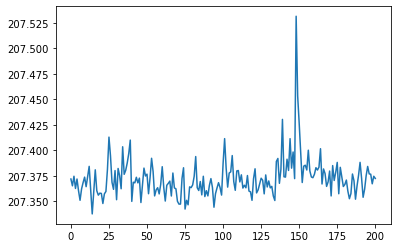

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x=np.linspace(0,200,201)
y=test_predict[0:201]

plt.plot(x,y)
plt.show()